# Respiratory Rate Estimation

Seismocardiography ([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure the Heart Rate (HR) and Respiratory Rate (RR) with a detector positioned above the sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography ([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with a combination of both an accelerometer and a gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., the accelerometer platform can be mounted under the slats of the bed).   
  
MuSe (Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provided by [221e](https://www.221e.com). In the context of this project, it allows to record the inertial data necessary for the estimation of SCG and BCG.

The goal of this assignment is to estimate the respiratory rate of an healthy subject, given the linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform.

The study must be performed on two datasets: the first is the compulsory one (`center_sternum.txt`), while the second is left at the discretion of the group, among those made available for the assignment.

*Remember that normal heart rate is around [40-100] bpm.*


## Data

The data is provided in `.txt` files. During this study, two healthy subjects were involved with their informed consent. The first dataset was recorded on one subject, while all the other datasets were recorded on the second subject. 

This is the first mandatory file:

* `center_sternum.txt`: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side, respectively. 


Choose one of the following files in order to complete the task.

* `1_Stave_supine_static.txt`: Sensor placed on a bed stave, under the mattress at the level of the chest. The subject was lying supine on his left and right side. 
* `2_Mattress_supine.txt`: Sensor placed on the mattress, near one corner but not under the pillow. The subject laid in the same position as above. 
* `3_Subject_sitting_chair.txt`: Sensor placed on the desk: the subject, sitting on a chair, leaned forearms and hands on the desk. 
* `4_Chest_sweater.txt`: Sensor placed on the subject chest directly on a sweater. 
* `5_Under_chair.txt`: Subject sitting on a chair, sensor placed under the seat of the chair. 

All `.txt` files have 16 columns, containing: 

* Log Freq stands for the acquisition in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse system.

Each dataset includes, in addition to the data, one file containing the adopted configuration of the MuSe(`config_1.txt` for the first measurement, and in `config_5.txt` for the other measurement).
 


## Assignment



1. Data preparation:

    1.1. Load the txt files and select only the columns you are interested in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )
    
    1.2. Plot selected data as a function of time and choose a proper time window over which to perform the analysis. Pay attention on the time representation and the measurement unit.
    
    1.3. In order to do a proper job, decide whether to consider some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.  


    
2. Time and frequency analysis:

    2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.
    
    2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use the Fourier analysis to properly design the filters in the following step. 



3. Filter:
    
    Implement your own filter, trying to extrapolate the respiratory rate signal. Hints:
    
    (a) Directly from Fourier Analysis, look for the most interesting frequency band.
    
    (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.
        
    (c) Explore another methods by yourselves.
    
    Remember to always motivate your choice.
    
    
4. Metrics:

    4.1. Respiratory Rate Per Minute (RPM): extrapolate RPM, and make an histogram of the result. Does it follow a particular distribution?

    4.2. Respiratory Rate Variability (RRV): extrapolate RRV, explain why this parameter is important, and plot the results.


5. **Optional**: Elaborate a simple algorithm to extrapolate the respiratory rate even when the filter fails (e.g. look for a particular threshold...).  



6. Conclusion: 

    Summarise the obtained results, and specifically make a comparison between the two files analysed. Highlight the limitations and the critical issues encountered during the work, motivating the most relevant contribution given by your solution.

#### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as spy
import seaborn as sns
import sklearn


from scipy import fft, signal, interpolate
from sklearn import preprocessing

# 1 Analysis of center_sternum.txt

## 1.1 Data preparation

### 1.1.1 Load the raw data and select columns

In [2]:
df = pd.read_csv('center_sternum.txt', delimiter = "\t")
df = df[['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ']]
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178
1,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177
2,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177
3,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176
4,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176
...,...,...,...,...,...,...,...,...,...
16501,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126
16502,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125
16503,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125
16504,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124


### 1.1.2 Plot selected data and choose a proper time window 

First and last 10 seconds are very nosy, so we removed those data from the dataset

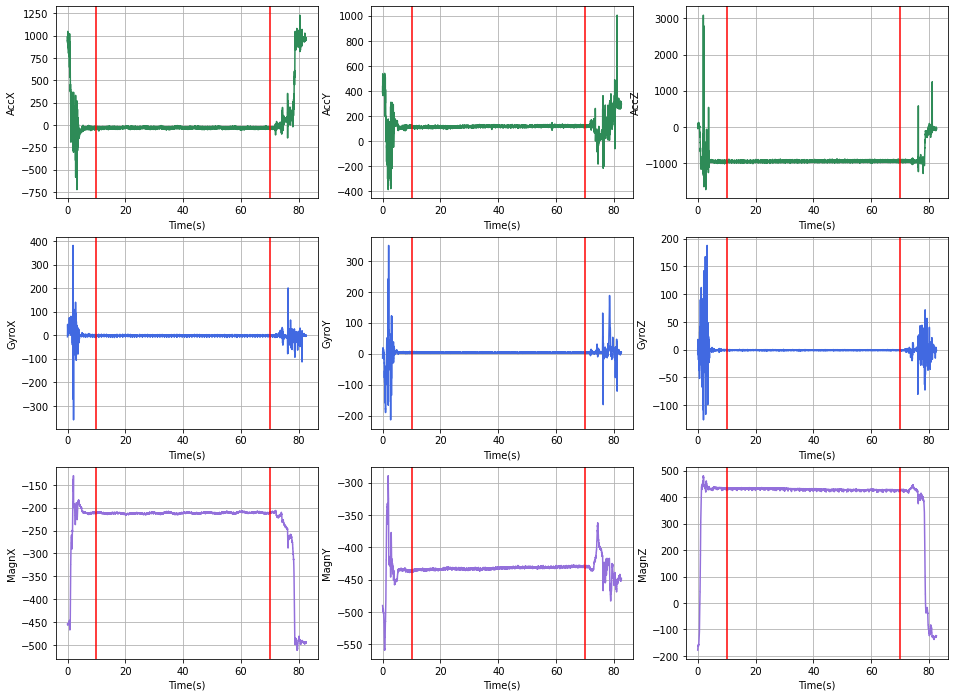

In [3]:
fs = 200
x = np.linspace(0, df.shape[0] / fs, df.shape[0])

y_label = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ']
color = ['seagreen', 'seagreen', 'seagreen', 'royalblue', 'royalblue', 'royalblue', 'mediumpurple', 'mediumpurple', 'mediumpurple']

fig, axs = plt.subplots(3, 3, figsize = (16, 12))
for i, ax in enumerate(axs.flat):
    ax.plot(x, df[y_label[i]], color = color[i])
    ax.axvline(x = 10, color = 'r')
    ax.axvline(x = 70, color = 'r')
    ax.set_xlabel('Time(s)')
    ax.set_ylabel(y_label[i])
    ax.grid()
    

#### Meaningful data

In [4]:
df2 = df.iloc[2000:14000, :].copy()
x = np.linspace(0, df2.shape[0]/fs, df2.shape[0])

df2
x.size

12000

### 1.1.3 Calibration

In [5]:
gyro_offset = np.array([-2.242224,2.963463,-0.718397])

acc_cal = np.array([[1.000966,-0.002326418,-0.0006995499],
                    [-0.002326379,0.9787045,-0.001540918],
                    [-0.0006995811,-0.001540928,1.00403]])
acc_offset = np.array([-3.929942,-13.74679,60.67546])

magn_cal = np.array([[0.9192851,-0.02325168,0.003480837],
                   [-0.02325175,0.914876,0.004257396],
                   [0.003481006,0.004257583,0.8748001]])
magn_offset = np.array([-95.67974,-244.9142,17.71132])

df2[['GyroX','GyroY','GyroZ']] = df2[['GyroX','GyroY','GyroZ']] + gyro_offset
df2[['AccX','AccY','AccZ']] = np.dot(df2[['AccX','AccY','AccZ']], acc_cal.T) + acc_offset
df2[['MagnX','MagnY','MagnZ']] = np.dot(df2[['MagnX','MagnY','MagnZ']], magn_cal.T) + magn_offset

df2

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
2000,-36.191918,98.305357,-897.115495,-0.486499,7.986364,-1.527557,-278.856972,-639.776198,393.017911
2001,-22.684157,97.764133,-915.007862,-0.684972,7.161936,-1.802366,-278.856972,-639.776198,393.017911
2002,-31.003173,96.009994,-887.561201,-1.310926,7.284074,-1.817634,-278.021365,-637.071851,389.534964
2003,-25.334931,99.274992,-884.079327,-1.295659,7.100867,-1.985573,-278.021365,-637.071851,389.534964
2004,-35.980596,103.453468,-867.603353,-1.219323,7.665753,-1.710763,-278.876743,-638.857065,393.896969
...,...,...,...,...,...,...,...,...,...
13995,-40.052097,98.944783,-880.026254,-5.387262,6.429112,-1.329084,-278.141105,-632.501729,388.681452
13996,-34.443708,104.012984,-884.386623,-5.417797,6.322242,-1.497023,-277.245071,-631.610104,388.689191
13997,-36.395733,103.541515,-885.425685,-5.234590,6.642852,-1.268015,-277.245071,-631.610104,388.689191
13998,-26.245083,99.049690,-891.489056,-5.265125,6.749723,-1.283282,-278.117853,-633.416605,388.677195


### 1.1.4 Plot meaningful data

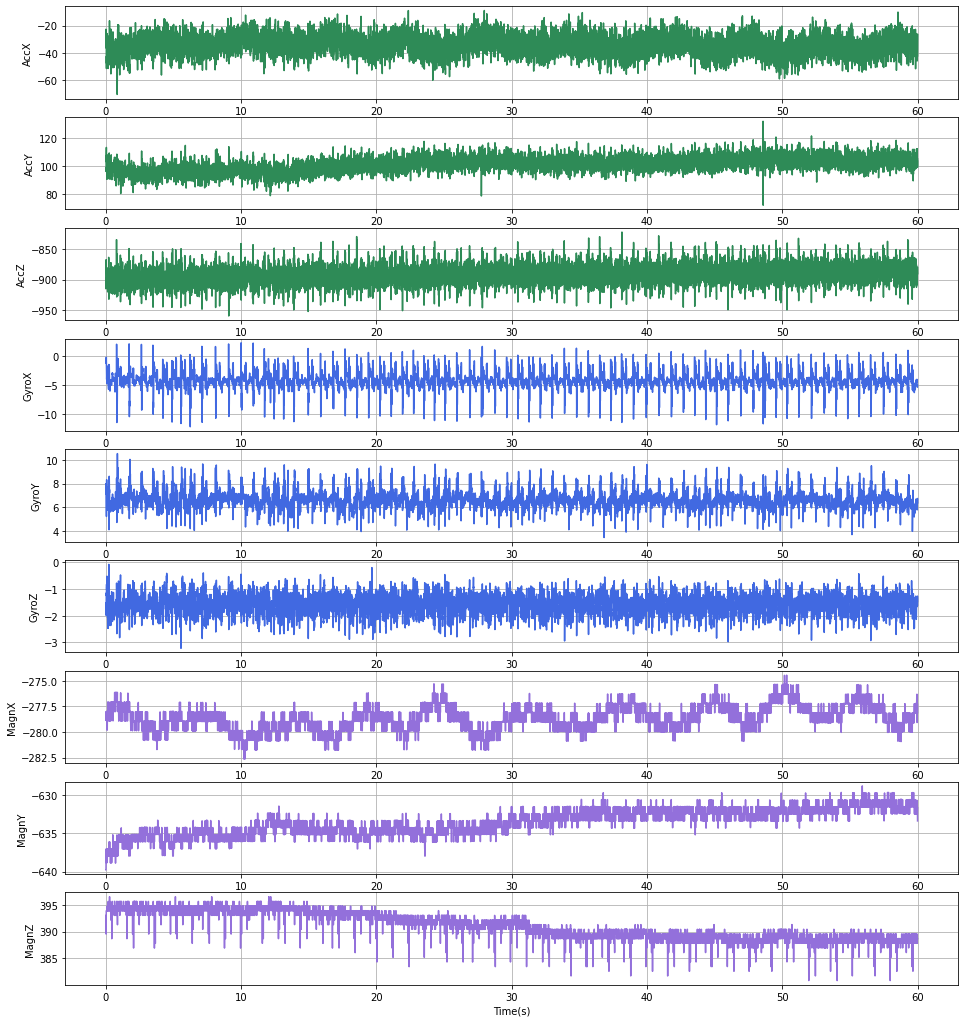

In [6]:
fig, axs = plt.subplots(9, 1, figsize = (16, 18))
for i, ax in enumerate(axs.flat):
    ax.plot(x, df2[y_label[i]], color = color[i])
    ax.set_xlabel('Time(s)')
    ax.set_ylabel(y_label[i])
    ax.grid()

## 1.2 Time and frequency analysis
### 1.2.1 Statistical analysis
#### Mean, median, variance, standard deviation, 25th and 75th percentiles

In [7]:
#stat = pd.DataFrame({'Mean': df2.mean(), 'Median': df2.median(), 'Variance': df2.var(), 'Standard deviation': df2.std(),
#    '25% percentile': df2.quantile(q = 0.25), '75% percentile': df2.quantile(q = 0.75)})

stat = df2.describe()
stat

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,-34.234293,100.900265,-892.401054,-4.326728,6.646299,-1.587087,-278.667645,-633.583895,391.063967
std,7.018565,5.214543,14.456269,1.413005,0.712699,0.362975,1.212739,1.662086,2.553438
min,-70.523078,71.834825,-959.109087,-12.242224,3.467280,-3.222214,-282.650371,-639.776198,380.808251
25%,-38.854045,97.480937,-900.970347,-4.929247,6.245906,-1.817634,-279.106893,-635.170051,388.688414
50%,-34.158425,101.068429,-892.838259,-4.394896,6.597051,-1.573359,-278.966269,-633.408090,390.435310
75%,-29.560357,104.345627,-884.565100,-3.723140,6.963463,-1.344351,-278.050465,-632.474220,393.902779
max,-8.963639,131.953547,-822.777963,2.231058,10.520715,-0.077176,-274.460483,-628.865476,396.544210


#### Correlation coefficients

In [8]:
df2_corr = df2.corr()
df2_corr

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
AccX,1.000000,-0.180828,-0.412005,0.203288,0.010442,0.025054,-0.386831,-0.051802,0.087693
AccY,-0.180828,1.000000,0.165032,-0.050947,-0.011371,-0.133083,0.243585,0.358844,-0.490141
AccZ,-0.412005,0.165032,1.000000,-0.079125,0.112730,0.025872,0.123488,0.190235,-0.236575
GyroX,0.203288,-0.050947,-0.079125,1.000000,0.395832,0.383160,-0.058950,-0.065203,0.026454
GyroY,0.010442,-0.011371,0.112730,0.395832,1.000000,0.436120,0.010498,-0.139320,0.027379
GyroZ,0.025054,-0.133083,0.025872,0.383160,0.436120,1.000000,-0.017122,-0.059217,0.008068
MagnX,-0.386831,0.243585,0.123488,-0.058950,0.010498,-0.017122,1.000000,0.255512,-0.326848
MagnY,-0.051802,0.358844,0.190235,-0.065203,-0.139320,-0.059217,0.255512,1.000000,-0.739075
MagnZ,0.087693,-0.490141,-0.236575,0.026454,0.027379,0.008068,-0.326848,-0.739075,1.000000


For better performance we normalized the data.

In [9]:
df_Norm = pd.DataFrame(preprocessing.normalize(df2), columns=df2.columns)
df_Norm

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,-0.029979,0.081431,-0.743122,-0.000403,0.006615,-0.001265,-0.230990,-0.529956,0.325555
1,-0.018590,0.080121,-0.749879,-0.000561,0.005869,-0.001477,-0.228533,-0.524318,0.322091
2,-0.025900,0.080206,-0.741466,-0.001095,0.006085,-0.001518,-0.232258,-0.532208,0.325416
3,-0.021208,0.083104,-0.740070,-0.001085,0.005944,-0.001662,-0.232734,-0.533298,0.326083
4,-0.030346,0.087252,-0.731728,-0.001028,0.006465,-0.001443,-0.235202,-0.538806,0.332209
...,...,...,...,...,...,...,...,...,...
11995,-0.033677,0.083197,-0.739960,-0.004530,0.005406,-0.001118,-0.233872,-0.531832,0.326819
11996,-0.028893,0.087252,-0.741876,-0.004545,0.005303,-0.001256,-0.232570,-0.529832,0.326055
11997,-0.030511,0.086799,-0.742256,-0.004388,0.005569,-0.001063,-0.232416,-0.529481,0.325840
11998,-0.021909,0.082686,-0.744210,-0.004395,0.005635,-0.001071,-0.232171,-0.528773,0.324466


## 1.2.2 Frequency Analysis
### 1.2.2.1 FFT

In [10]:
#df_fft = pd.DataFrame(columns=df_Norm.columns)
#df_fft_pwr = pd.DataFrame(columns=df_Norm.columns)
#for c in df_Norm.columns:
#    df_fft[c] = fft.fft(np.array(df_Norm[c]))
#    df_fft_pwr[c] = np.abs(df_fft[c])
#df_fft_pwr



df_fft = df_Norm.apply(np.fft.fft)
df_fft_pwr = df_fft.apply(np.abs)

df_fft_pwr

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,342.629562,1009.184056,8923.482928,43.281434,66.475399,15.871436,2786.906090,6336.357629,3910.906589
1,8.463527,18.466693,3.213201,0.351673,0.081031,0.090543,2.347114,4.532672,6.993955
2,5.074013,12.895324,3.622327,0.256056,0.062612,0.037271,0.521487,3.396698,1.157646
3,1.780935,2.345899,0.501682,0.108782,0.057936,0.037804,1.876865,0.324252,0.808074
4,3.305870,2.792065,1.132852,0.103935,0.095672,0.025544,1.936690,0.590333,0.488120
...,...,...,...,...,...,...,...,...,...
11995,1.180512,3.017132,1.012112,0.091110,0.054812,0.018515,1.079101,0.974040,0.753025
11996,3.305870,2.792065,1.132852,0.103935,0.095672,0.025544,1.936690,0.590333,0.488120
11997,1.780935,2.345899,0.501682,0.108782,0.057936,0.037804,1.876865,0.324252,0.808074
11998,5.074013,12.895324,3.622327,0.256056,0.062612,0.037271,0.521487,3.396698,1.157646


In [11]:
freq = fft.fftfreq(df_fft.shape[0] , d=1/fs)
freq

array([ 0.        ,  0.01666667,  0.03333333, ..., -0.05      ,
       -0.03333333, -0.01666667])

Removing bias (power at zero frequency).

In [12]:
df_fft_pwr.loc[0] = 0
df_fft_pwr

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,8.463527,18.466693,3.213201,0.351673,0.081031,0.090543,2.347114,4.532672,6.993955
2,5.074013,12.895324,3.622327,0.256056,0.062612,0.037271,0.521487,3.396698,1.157646
3,1.780935,2.345899,0.501682,0.108782,0.057936,0.037804,1.876865,0.324252,0.808074
4,3.305870,2.792065,1.132852,0.103935,0.095672,0.025544,1.936690,0.590333,0.488120
...,...,...,...,...,...,...,...,...,...
11995,1.180512,3.017132,1.012112,0.091110,0.054812,0.018515,1.079101,0.974040,0.753025
11996,3.305870,2.792065,1.132852,0.103935,0.095672,0.025544,1.936690,0.590333,0.488120
11997,1.780935,2.345899,0.501682,0.108782,0.057936,0.037804,1.876865,0.324252,0.808074
11998,5.074013,12.895324,3.622327,0.256056,0.062612,0.037271,0.521487,3.396698,1.157646


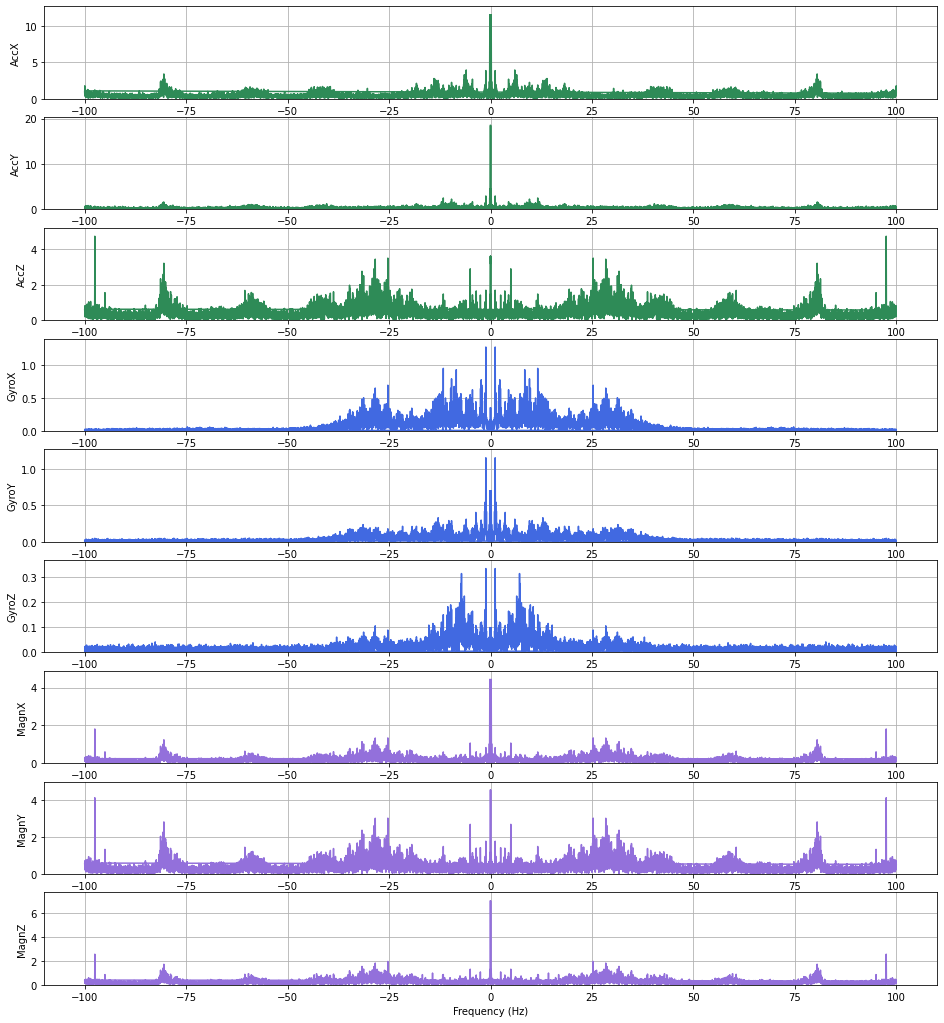

In [13]:
fig, axs = plt.subplots(9,1, figsize = (16,18))
for i, ax in enumerate(axs.flat):   
    
    _d = np.array(df_fft_pwr.iloc[:,i])
    _peaks, _property = signal.find_peaks(_d, distance=fs)
    
        
    ax.set_ylim([0, _d[_peaks].max()*1.1])
    ax.plot(freq, _d, color=color[i])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(df_fft_pwr.columns[i])
    ax.grid()
    #ax.set_xlim([-5,5])
    #ax.axvline(x = 0.16, color = 'r')
    #ax.axvline(x = 1.16, color = 'r')
    

From frequency spectrum it is obvious that main information is in frequencies below 40 Hz. However, different approches could be used to find HR and RR. Cut-off frequencies of filter depends on the selected approach.

### 1.2.2.2 Finding HR and RR in frequency domain

Normal heart rate is between 40 bpm and 100 bpm, while maximum HR during exercises is up to 255-age bpm, though it depends on the age. Normal respiratory rate is between 10 and 20 breaths per minute for adults, while for childs it could be up to 60 breaths per minue. From these facts it is concluded that main frequencies should be less than 4.25 Hz for HR and less than 1 for RR, which are confirmed by low-frequency high-power harmonics in the spectrum. 

Considering that our goal is to estimate the respiratory rate of an healthy subject, and we do not need clear HR waveform or other specific properties of HR wavefor, we use a bandpass filter with cut-off frequencies equal to 0.04 Hz and 2 Hz.



In [14]:
df_fft_pwr = df_fft_pwr.drop(df_fft_pwr[freq <= 0].index)
freq = freq[np.where(freq > 0)]

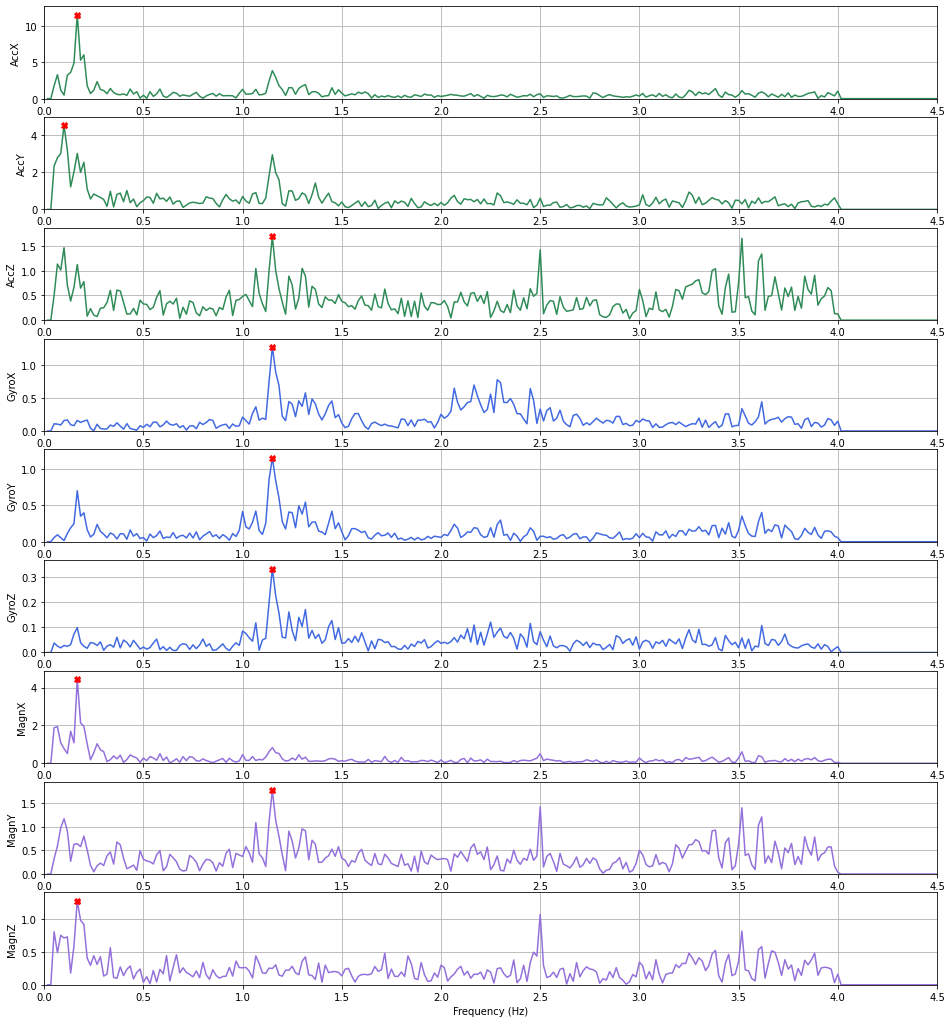

In [15]:

f_low_cut = 0.04
f_high_cut = 4

peak_freq = []

fig, axs = plt.subplots(9,1, figsize = (16,18))

for i, ax in enumerate(axs.flat): 
    
    
    #### Filtering frequencies
    _d = np.array(df_fft_pwr.iloc[:,i])
    _mask = np.where(np.abs(freq) < f_low_cut)
    _d[_mask] = 0
    _mask = np.where(np.abs(freq) > f_high_cut)
    _d[_mask] = 0

    
    # Finding freq. with peak power
    peak_freq.append(freq[_d.argmax()])
        
    ax.plot(freq, _d , color=color[i])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(df_fft_pwr.columns[i])
    ax.grid()
    
    ax.set_xlim([0,4.5])
    ax.set_ylim([0, (_d[_d.argmax()])*1.1])
    ax.plot(freq[_d.argmax()], _d[_d.argmax()], 'X', color='r')


By selecting main peak in the [0.04,4] Hz interval and voting on all signals, HR and RR could be find.

In [16]:
F = np.array(np.unique(peak_freq , return_counts=True))[0,-2:]
HR = F.max()
RR = F.min()
print(f'HR frequency is {HR:.2f} Hz, which is equal to {HR*60:.2f} beats per minute.')
print(f'RR frequency is {RR:.2f} Hz, which is equal to {RR*60:.2f} breath per minute.')


HR frequency is 1.15 Hz, which is equal to 69.00 beats per minute.
RR frequency is 0.17 Hz, which is equal to 10.00 breath per minute.


### 1.2.2.3 Time domain analysis on filtered signal

Although the previous method can be used to obtain heart rate and respiration rate, this method does not seem very suitable for a more complete analysis. Therefore, after applying the appropriate filter on the data and removing unwanted noise and frequencies, we perform the analysis in the time domain.

To do this, we perform a bandpass filter on data with [0.04 , 40] Hz allow band.

In [17]:

df_fft = df2.apply(np.fft.fft)
df_fft_pwr = df_fft.apply(np.abs)
freq = fft.fftfreq(df_fft.shape[0] , d=1/fs)

df_fft_pwr

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
2000,410811.510805,1.210803e+06,1.070881e+07,51920.733935,79755.586953,19045.038962,3.344012e+06,7.603007e+06,4.692768e+06
2001,9453.663390,1.989716e+04,2.470176e+04,326.198820,249.945337,75.977621,4.538283e+03,9.686936e+03,1.761991e+04
2002,5777.161481,1.449653e+04,1.321683e+04,278.309930,116.425003,31.234796,2.621434e+03,2.473340e+03,5.136401e+03
2003,2243.200953,2.100411e+03,6.801255e+03,100.776231,117.000891,42.423358,5.844882e+02,4.926523e+03,3.577497e+03
2004,4070.918713,2.829180e+03,6.064432e+03,104.869539,96.108041,31.780648,1.385260e+03,2.678999e+03,2.305754e+03
...,...,...,...,...,...,...,...,...,...
13995,1482.671675,3.157521e+03,5.441054e+03,94.008742,94.081503,16.022779,2.805044e+02,1.828055e+03,2.698466e+03
13996,4070.918713,2.829180e+03,6.064432e+03,104.869539,96.108041,31.780648,1.385260e+03,2.678999e+03,2.305754e+03
13997,2243.200953,2.100411e+03,6.801255e+03,100.776231,117.000891,42.423358,5.844882e+02,4.926523e+03,3.577497e+03
13998,5777.161481,1.449653e+04,1.321683e+04,278.309930,116.425003,31.234796,2.621434e+03,2.473340e+03,5.136401e+03


In [18]:
f_low_cut = 0.04
f_high_cut = 40

In [19]:
df_fpf = df_fft_pwr.copy()      #df_fft_pwr_filtered ==> df_fpf


#sos = signal.butter(4, [f_low_cut, f_high_cut], fs=fs, btype="band", output="sos")
sos = signal.butter(10,  f_high_cut, fs=fs, btype="low", output="sos")

sos
#df_fpf.loc[np.abs(freq) > f_high_cut] *= 0.01
#df_fpf.loc[np.abs(freq) < f_low_cut] *= 0.01
#df_fpf

array([[ 4.99454078e-04,  9.98908156e-04,  4.99454078e-04,
         1.00000000e+00, -3.18681417e-01,  3.12747301e-02],
       [ 1.00000000e+00,  2.00000000e+00,  1.00000000e+00,
         1.00000000e+00, -3.34543036e-01,  8.26040059e-02],
       [ 1.00000000e+00,  2.00000000e+00,  1.00000000e+00,
         1.00000000e+00, -3.69527377e-01,  1.95815713e-01],
       [ 1.00000000e+00,  2.00000000e+00,  1.00000000e+00,
         1.00000000e+00, -4.31657124e-01,  3.96871795e-01],
       [ 1.00000000e+00,  2.00000000e+00,  1.00000000e+00,
         1.00000000e+00, -5.37992527e-01,  7.40980389e-01]])

In [20]:
filtered_df = df.apply(lambda x: signal.sosfilt(sos,x)).copy()



#filtered_df = df_fpf.apply(np.fft.ifft)
# only take the real part
real_filtered_df = filtered_df.apply(np.real)
real_filtered_df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,0.473026,0.217593,0.035280,-0.003408,-0.007114,0.000702,-0.226752,-0.244732,-0.088903
1,6.156772,2.803141,0.467487,-0.037788,-0.091457,0.004433,-2.946055,-3.179663,-1.154562
2,37.459447,16.846384,2.895745,-0.181648,-0.544745,-0.005243,-17.883171,-19.301219,-7.004974
3,141.342349,62.649038,11.125999,-0.460056,-1.982722,-0.156988,-67.282378,-72.618543,-26.339545
4,369.809752,161.197262,29.666184,-0.447812,-4.875655,-0.811551,-175.423150,-189.346334,-68.623551
...,...,...,...,...,...,...,...,...,...
16501,957.498290,273.839993,-31.650246,-0.226515,1.508637,-0.603883,-494.659293,-450.492603,-124.993429
16502,958.857412,270.252541,-33.610835,0.555132,2.069613,-0.590610,-494.565944,-450.266207,-125.316373
16503,961.666062,268.920976,-38.312232,1.030481,2.387253,-0.699830,-494.377212,-449.746754,-125.771762
16504,961.985063,274.560595,-40.966914,1.222829,2.493753,-0.745583,-494.029279,-449.368269,-126.110940


In [21]:
real_filtered_df.describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
count,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000
mean,35.347769,121.675511,-896.986974,-1.885931,3.635658,-0.818077,-231.196101,-432.517752,397.936232
std,231.908723,61.327615,212.193057,12.928877,17.292850,10.538856,67.147315,17.874969,123.744207
min,-358.206058,-342.649399,-2117.053681,-281.836976,-215.292880,-121.058984,-552.317943,-596.886868,-214.969078
25%,-34.189162,111.575324,-955.953270,-2.829379,3.211656,-1.167020,-213.078348,-434.165192,426.908014
50%,-29.835042,116.078514,-948.844686,-2.116836,3.668227,-0.848030,-211.836027,-432.452069,429.131427
75%,-24.448263,119.787968,-941.063521,-1.207789,4.179717,-0.564436,-210.708784,-430.552380,432.836589
max,1179.086123,726.477373,1716.190896,354.407238,298.167565,165.099537,-0.226752,-0.244732,480.762822


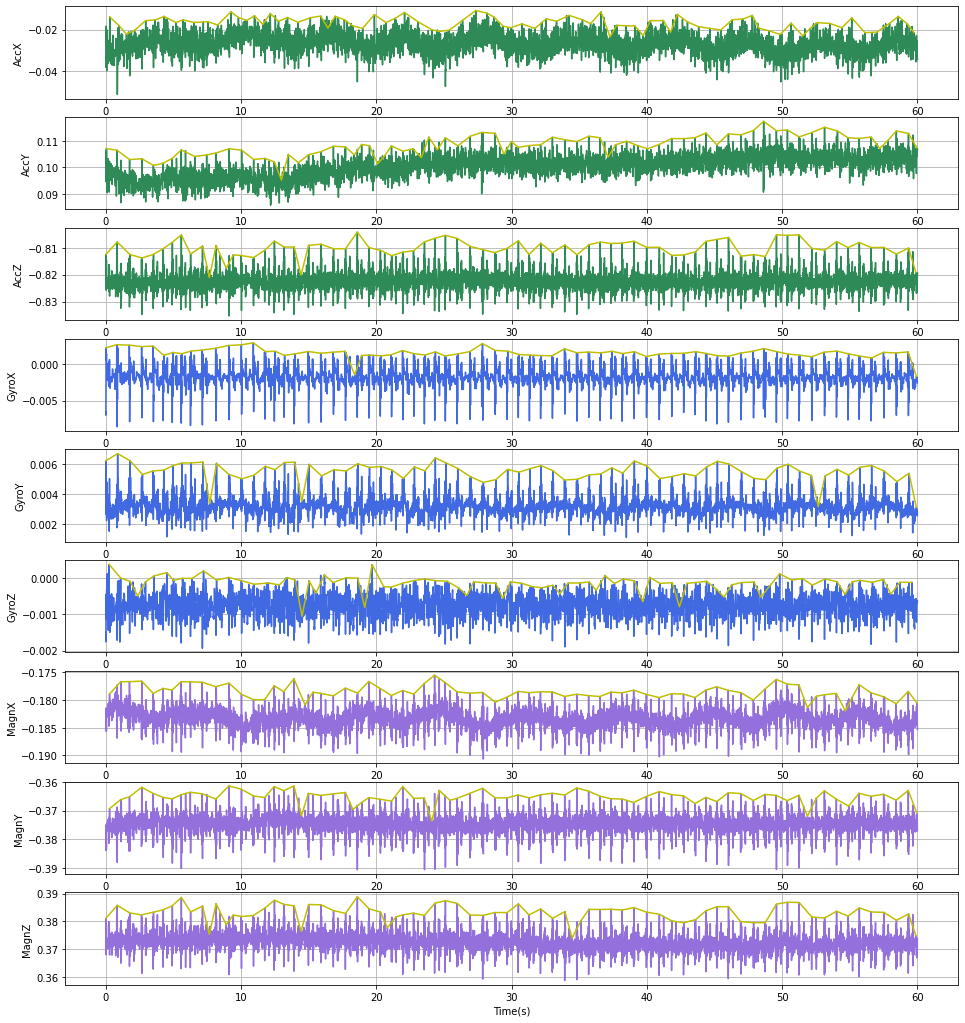

In [75]:
real_filtered_df2 = real_filtered_df.iloc[2000:14000, :].copy()

#df_Norm = df2.apply(lambda x: sklearn.preprocessing.normalize)
real_filtered_df2 = pd.DataFrame(preprocessing.normalize(real_filtered_df2), columns=real_filtered_df.columns)




x = np.linspace(real_filtered_df2.index.start,real_filtered_df2.index.stop/fs, real_filtered_df2.shape[0])


peak_freq=real_filtered_df2.apply(lambda x: signal.find_peaks(x, distance=fs/2))




fig, axs = plt.subplots(9, 1, figsize = (16, 18))
for i, ax in enumerate(axs.flat):
    
    _c = y_label[i]
    _d = real_filtered_df2[y_label[i]]
    _p = [x for x in list(peak_freq[_c][0])]

#    print(f'Size of _p : {len(_p)}, column: {y_label[i]}, size of column: {_d.shape}')
#    print(_d[_p])
#    print(_p,'\n***********************\n',)
    
    ax.plot(x, real_filtered_df2[y_label[i]], color = color[i])
    ax.set_xlabel('Time(s)')
    ax.set_ylabel(y_label[i])
    ax.grid()
    

    ax.plot(x[peak_freq[_c][0]], _d[_p],color='y')
#    ax.axvline(x[_p])
#    ax.axhline(_d.mean()+_d.std(),color='r')
    #ax.set_xlim([10,20])
    #ax.set_ylim([-20, 20])
    


Now we can use time domain analysis to find our goals. The best signal for HR is GyroX and for RR is MagnX.

In [ ]:
a =list(peak_freq.iloc[0])
a

### Filtered signal

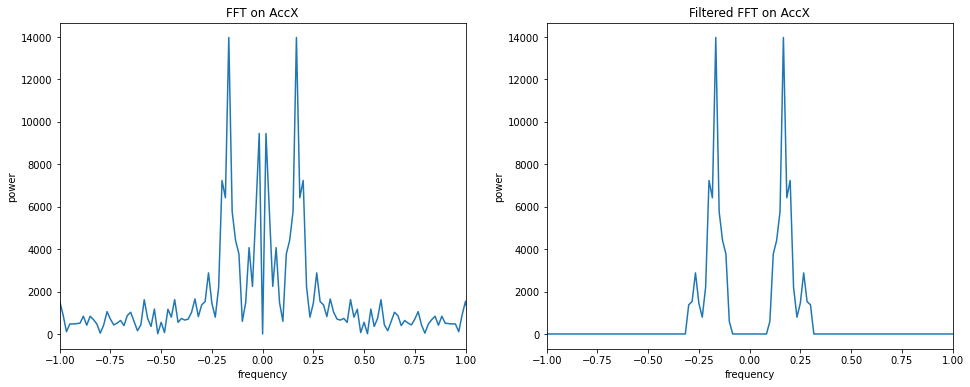

In [35]:
rr_int = [0.1, 0.3]

def fft(sig_name):
    # The FFT of the signal
    sig = df2[sig_name].to_numpy()
    sig -= np.mean(sig)
    sig_fft = fftpack.fft(sig)

    # And the power (sig_fft is of complex dtype)
    power = np.abs(sig_fft) # these are the "weights" of the Fourier components for each discrete frequency interval

    # The return the corresponding frequencies
    sample_freq = fftpack.fftfreq(sig.size, d=1/freq)
    return sig_fft, power, sample_freq


sig_fft_AccX, power_AccX, sample_freq_AccX = fft('AccX')
filter_fft = np.where((np.abs(sample_freq_AccX)<rr_int[0]) | (np.abs(sample_freq_AccX) >rr_int[1]))
sig_fft_AccX[filter_fft] = 0

df_fft = pd.DataFrame(list(zip(sample_freq_AccX, power_AccX, np.abs(sig_fft_AccX))), columns = ['sample_freq', 'power', 'filtered_fft'])
df_fft = df_fft.sort_values(by=['sample_freq', 'power', 'filtered_fft'])

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (16,6))
ax1.plot(df_fft['sample_freq'],df_fft['power'])
ax1.set_xlim(-1,1)
ax1.set(xlabel="frequency", ylabel="power",title="FFT on AccX")
ax2.plot(df_fft['sample_freq'],df_fft['filtered_fft'])
ax2.set_xlim(-1,1)
ax2.set(xlabel="frequency", ylabel="power",title="Filtered FFT on AccX")
plt.show()

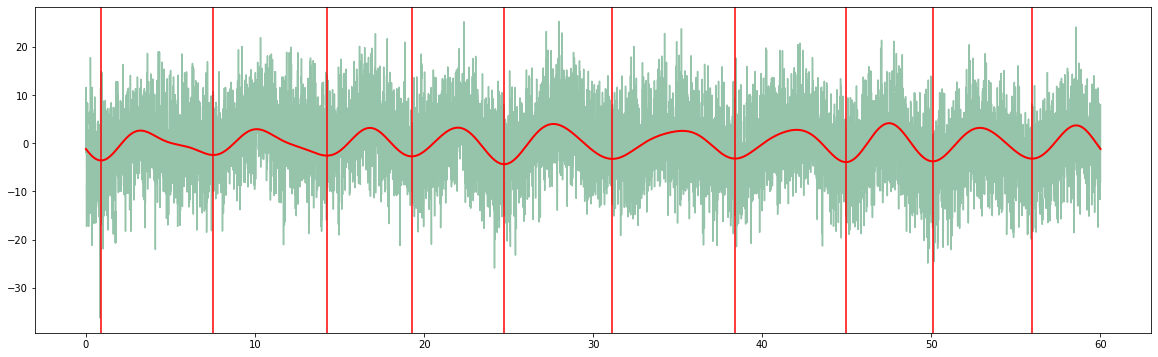

In [50]:
from scipy import signal

filtered_sig = fftpack.ifft(sig_fft_AccX)
filtered_sig = np.real(filtered_sig)

plt.figure(figsize=(20, 6))

plt.plot(x, df2['AccX'], alpha=0.5, color='seagreen', label='Original AccX')
plt.plot(x, filtered_sig, linewidth=2, color='red', label='Filtered AccX')

## Min of the filtered signal
minima = signal.argrelextrema(filtered_sig, np.less, order = 500)
for i in minima[0]:
    plt.axvline(x[i], color = 'red')
    
#plt.xlabel('Time [s]')
#plt.xlabel('Time [s]')
#plt.ylabel('Amplitude')
#plt.xlim(timeline[result][0],timeline[result][-1])
#plt.title('Original AccX vs Filtered AccX (range 5-65 seconds)')
#plt.legend(loc='best')
plt.show()

# 2 Analysis of 2_Mattress_supine.txt
## 2.1 Data preparation
### 2.1.1 Load the raw data and select columns

In [ ]:
df_m = pd.read_csv('2_Mattress_supine.txt', delimiter = "\t")
df_m = df_m[['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ']]
df_m

### 2.1.2 Plot selected data and choose a proper time window 

In [ ]:
fs_m = 100
x = np.linspace(0, df_m.shape[0] / fs_m, df_m.shape[0])

y_label = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ']
color = ['seagreen', 'seagreen', 'seagreen', 'royalblue', 'royalblue', 'royalblue', 'mediumpurple', 'mediumpurple', 'mediumpurple']

fig, axs = plt.subplots(3, 3, figsize = (20, 12))
for i, ax in enumerate(axs.flat):
    ax.plot(x, df_m[y_label[i]], color = color[i])
    ax.axvline(x = 12, color = 'r')
    ax.axvline(x = 112, color = 'r')
    ax.set_xlabel('Time(s)')
    ax.set_ylabel(y_label[i])
    

#### Meaningful data

In [ ]:
df2_m = df_m.iloc[1200:11200, :].copy()
x = np.linspace(0, 100, 10000)
df2_m

### 2.1.3 Calibration

In [ ]:
gyro_offset = np.array([-2.804399,1.793105,0.3411708])

acc_cal = np.array([[1.002982,9.415505E-05,0.00434674],
                    [9.04459E-05,1.002731,-0.001444198],
                    [0.004346536,-0.001444751,1.030587]])
acc_offset = np.array([3.602701,-20.96658,54.97186])

magn_cal = np.array([[1.013437,-0.04728858,-0.001861475],
                   [-0.04728862,1.004832,0.008222118],
                   [-0.001861605,0.008221965,0.9439077]])
magn_offset = np.array([-150.4098,74.62431,630.9805])

df2_m[['GyroX','GyroY','GyroZ']] = df2_m[['GyroX','GyroY','GyroZ']] + gyro_offset.T
df2_m[['AccX','AccY','AccZ']] = np.dot(df2_m[['AccX','AccY','AccZ']],acc_cal.T) + acc_offset.T
df2_m[['MagnX','MagnY','MagnZ']] = np.dot(df2_m[['MagnX','MagnY','MagnZ']],magn_cal.T) + magn_offset.T

### 2.1.4 Plot meaningful data

In [ ]:
fig, axs = plt.subplots(9, 1, figsize = (20, 16))
for i, ax in enumerate(axs.flat):
    ax.plot(x, df2_m[y_label[i]], color = color[i])
    ax.set_xlabel('Time(s)')
    ax.set_ylabel(y_label[i])

## 2.2 Time and frequency analysis
### 2.2.1 Statistical analysis
#### Mean, median, variance, standard deviation, 25th and 75th percentiles

In [ ]:
stat = pd.DataFrame({'Mean': df2_m.mean(), 'Median': df2_m.median(), 'Variance': df2_m.var(), 'Standard deviation': df2_m.std(),
    '25% percentile': df2_m.quantile(q = 0.25), '75% percentile': df2_m.quantile(q = 0.75)})
stat

#### Correlation coefficients

In [ ]:
df2_m_corr = df2_m.corr()
df2_m_corr